# TavilySearchResults
https://github.com/teddylee777/langchain-kr/blob/6f76b9eaede6ce115334ad40294dc264189b30e0/17-LangGraph/04-langgraph-search-or-retrieve.ipynb#L56

In [1]:
import os
import pprint
from dotenv import load_dotenv
## langsmith
from langsmith import Client
from langchain_teddynote import logging
## OpenAI
from langchain_openai import ChatOpenAI
from langchain.schema import ChatMessage, AIMessage, HumanMessage, SystemMessage
from langchain.embeddings.openai import OpenAIEmbeddings
## ChromaDB
import chromadb
from langchain.vectorstores import Chroma
## History
from operator import itemgetter
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.chat_message_histories import ChatMessageHistory, StreamlitChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
## LangGraph
from typing import TypedDict
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import GraphRecursionError
from langchain_community.tools.tavily_search import TavilySearchResults
## Google Search
from langchain_google_community import GoogleSearchAPIWrapper
from langchain_core.tools import Tool
## gradio
import gradio as gr

/Users/jeongyunl/opt/anaconda3/envs/juso-chatbot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# .env 파일 활성화 & API KEY 설정
load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')

logging.langsmith("240731") 

LangSmith 추적을 시작합니다.
[프로젝트명]
240731


In [3]:
store = {}

# 세션 ID를 기반으로 세션 기록을 가져오는 함수
def get_session_history(session_ids):
    if session_ids not in store:  # 세션 ID가 store에 없는 경우
        # 새로운 ChatMessageHistory 객체를 생성하여 store에 저장
        store[session_ids] = ChatMessageHistory()
    return store[session_ids]  # 해당 세션 ID에 대한 세션 기록 반환
    
##############################################################################################################
################################################Retriever#####################################################
##############################################################################################################
class MultiCollectionRetriever:
    def __init__(self, client, collection_names, embedding_function, search_kwargs={"k": 2}):
        self.collections = [
            Chroma(client=client, collection_name=name, embedding_function=embedding_function)
            for name in collection_names
        ]
        self.search_kwargs = search_kwargs

    def retrieve(self, query):
        results = []
        for collection in self.collections:
            # 각 컬렉션에서 유사도 검색 수행
            documents_with_scores = collection.similarity_search_with_score(query, **self.search_kwargs)
            results.extend(documents_with_scores)
        
        # 유사도 점수를 기준으로 결과 정렬 (score가 높을수록 유사도가 높음)
        results.sort(key=lambda x: x[1], reverse=False)

        documents = [(doc, score) for doc, score in results]
        return documents

# 사용 예시
client = chromadb.PersistentClient('../juso-chat-bot-v0.1/chroma/')
collection_names = ["csv_files_openai_3072", "49_files_openai_3072"]
embedding = OpenAIEmbeddings(model='text-embedding-3-large') 
multi_retriever = MultiCollectionRetriever(client, collection_names, embedding)

##############################################################################################################
################################################GraphState####################################################
##############################################################################################################
# GraphState 상태를 저장하는 용도
class GraphState(TypedDict):
    question: str  # 질문
    context: str  # 문서의 검색 결과
    answer: str  # llm이 생성한 답변
    relevance: str  # 답변의 문서에 대한 관련성 (groundness check)
    
##############################################################################################################
################################################vector Retriever##############################################
##############################################################################################################
def retrieve_document(state: GraphState) -> GraphState:
    # Question 에 대한 문서 검색을 retriever 로 수행합니다.
    retrieved_docs = multi_retriever.retrieve(state["question"])
    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs[:2])

##############################################################################################################
################################################Groundness Checker ###########################################
##############################################################################################################
chat = ChatOpenAI(model="gpt-4o", api_key=openai_api_key)

def relevance_message(context, question):
    messages = [
        SystemMessage(content="""
            너는 Query와 Document를 비교해서 ['grounded', 'notGrounded', 'notSure'] 셋 중 하나의 라벨을 출력하는 모델이야.

            'grounded': Compare the Query and the Document. If the Document includes content that can be used to generate an answer to the Query, output the label 'grounded'.
            'notGrounded': Compare the Query and the Document. If the Document not includes content that can be used to generate an answer to the Query, output the label 'notGrounded'.
            'notSure': Compare the Query and the Document. If you cannot determine whether the Document includes content that can be used to generate an answer to the Query, output the label .notSure'.
            
            너의 출력은 반드시 'grounded', 'notGrounded', 'notSure' 중 하나여야 해. 띄어쓰기나 대소문자 구분 등 다른 형식이나 추가적인 설명 없이 오직 하나의 라벨만 출력해줘.
        """),
        HumanMessage(content=f"""
            [Document]
            {context}

            [Query]
            {question}
        """),
    ]
    return messages

def relevance_check(state: GraphState) -> GraphState:
    messages = relevance_message(state["context"], state["question"])
    response = chat.invoke(messages)
    return GraphState(
        relevance=response.content,
        context=state["context"],
        answer=state["answer"],
        question=state["question"],
    )

def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "grounded":
        return "grounded"
    elif state["relevance"] == "notGrounded":
        return "notGrounded"
    elif state["relevance"] == "notSure":
        return "notSure"
    
##############################################################################################################
################################################# Rewriter ###################################################
##############################################################################################################  
    
def rewrite(state):
    question = state["question"]
    answer = state["answer"]
    context = state["context"]
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a professional prompt rewriter. Your task is to generate the question in order to get additional information that is now shown in the context."
                "Your generated question will be searched on the web to find relevant information.",
            ),
            (
                "human",
                "Rewrite the question to get additional information to get the answer."
                "\n\nHere is the initial question:\n ------- \n{question}\n ------- \n"
                "\n\nHere is the initial context:\n ------- \n{context}\n ------- \n"
                "\n\nHere is the initial answer to the question:\n ------- \n{answer}\n ------- \n"
                "\n\nFormulate an improved question in Korean:",
            ),
        ]
    )

    # Question rewriting model
    model = ChatOpenAI(temperature=0, model="gpt-4o")

    chain = prompt | model | StrOutputParser()
    response = chain.invoke(
        {"question": question, "answer": answer, "context": context}
    )
    return GraphState(question=response)

    
##############################################################################################################
################################################Search on Web ################################################
##############################################################################################################  
    
def search_on_web(state: GraphState) -> GraphState:
    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    search_tool = TavilySearchResults(max_results=5)
    search_result = search_tool.invoke({"query": state["question"]})

    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(
        context=search_result,
    )

/Users/jeongyunl/opt/anaconda3/envs/juso-chatbot/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(
/Users/jeongyunl/opt/anaconda3/envs/juso-chatbot/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 0.4. An updated version of the class exists in the langchain-chroma package and should be used instead. To use it run `pip install -U langchain-chroma` and import as `from langchain_chroma import Chroma`.
  warn_deprecated(


In [4]:
##############################################################################################################
################################################LLM Answer Maker##############################################
##############################################################################################################

def llm_answer(state: GraphState) -> GraphState:
    
    # 프롬프트를 생성합니다.
    prompt = PromptTemplate.from_template(
        """
                너는 Context의 정보를 반드시 활용해서 답변을 생성하는 챗봇이야. 
                이때, 답변은 Context에 정보가 있을 수도 있고, 없을 수도 있어. 
                Context의 정보로 답변을 생성할 수 있는 경우 해당 정보를 활용하고, 만약 Context의 정보로 답변을 유추조차 할 수 없는 경우, Context를 참고하지 말고 그냥 너가 생각한 답변을 생성해줘.
                주소와 관련된 질문인 경우 최대한 Context의 답변을 기반을 참고해주고, 그렇지 않은 경우 그냥 너의 지식을 활용해줘.
                답변에는 Context라는 단어를 사용하지 말아줘.
                
                답변의 끝에는 '출처'를 작성해줘. 출처와 자세한 정보에 대한 내용은 다음과 같아. 
                
                '출처'는 Context의 'context'에 metadata의 'source'에 파일경로로 기입되어 있어. pdf, csv, md 등의 파일 이름으로만 출처를 기입해주면 돼. 'data/final'같은 경로는 작성해주지 않아도 돼.
                만약 여러개의 출처가 기입되어 있는 경우 모두 알려주고, 중복되는 경우 하나만 기입해줘.
                이때 파일명의 확장자(pdf, csv, md 등)는 기입하지 않아도 돼.
                만약 Context의 'context'에 metadata의 'source'가 없는 경우 그냥 아무것도 적지 않아도 돼.

                #Previous Chat History:
                {chat_history}

                #Question: 
                {question} 

                #Context: 
                {context} 

                #Answer:
                
            """
                )

    llm = ChatOpenAI(model_name="gpt-4o", temperature=0)
    
    # 프롬프트, 모델, 출력 파서를 체이닝합니다.
    chain = prompt | llm | StrOutputParser()

    # 대화를 기록하는 RAG 체인 생성
    rag_with_history = RunnableWithMessageHistory(
        chain,
        get_session_history,  # 세션 기록을 가져오는 함수
        input_messages_key="question",  # 사용자의 질문이 템플릿 변수에 들어갈 key
        history_messages_key="chat_history",  # 기록 메시지의 키
    )
    
    # 상태에서 질문과 대화 기록을 가져옵니다.
    input_data = {
        'question': state["question"],
        'chat_history': itemgetter("chat_history"),
        'context': state["context"]
    }
    
    print(state['context'])

    response = rag_with_history.invoke(input_data, config={"configurable": {"session_id": "rag123"}})
    
    return GraphState(
        answer=response,
        context=state["context"],
        question=state["question"],
    )

In [5]:
##############################################################################################################
################################################Setting Graph Relations#######################################
##############################################################################################################

workflow = StateGraph(GraphState)

# 노드들을 정의합니다.
workflow.add_node("retrieve", retrieve_document)  # 답변을 검색해오는 노드를 추가합니다.
workflow.add_node("llm_answer", llm_answer)  # 답변을 생성하는 노드를 추가합니다.
workflow.add_node("relevance_check", relevance_check)  # 답변의 문서에 대한 관련성 체크 노드를 추가합니다.
workflow.add_node("rewrite", rewrite)  # 질문을 재작성하는 노드를 추가합니다.
workflow.add_node("search_on_web", search_on_web)  # 웹 검색 노드를 추가합니다.

workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 답변
workflow.add_edge("rewrite", "search_on_web")  # 재작성 -> 관련성 체크
workflow.add_edge("search_on_web", "relevance_check")  # 웹 검색 -> 답변

# 조건부 엣지를 추가합니다.
workflow.add_conditional_edges(
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.
    is_relevant,
    {
        "grounded": "llm_answer",  # 관련성이 있으면 종료합니다.
        "notGrounded": "rewrite",  # 관련성이 없으면 다시 질문을 작성합니다.
        "notSure": "rewrite",  # 관련성 체크 결과가 모호하다면 다시 질문을 작성합니다.
    },
)

workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 시작점을 설정합니다.
workflow.set_entry_point("retrieve")

# 기록을 위한 메모리 저장소를 설정합니다.
memory = MemorySaver()

# 그래프를 컴파일합니다.
app = workflow.compile(checkpointer=memory)

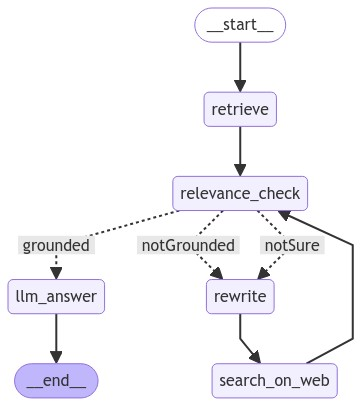

In [6]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [7]:
# config = RunnableConfig(
#     recursion_limit=12, configurable={"thread_id": "CORRECTIVE-SEARCH-RAG"}
# )

In [8]:
# list(app.stream({'question':"도로명주소법 2조의 내용은?"}, config=config))

Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')


[(Document(metadata={'source': 'data/final/[1018] 주소정보_업무편람_최종(하이퍼링크).docx'}, page_content='제2절 주소정보 개념\n\n\n가. 사전적 의미\n\n1) 국어사전\n\n사람 또는 기업이 살거나 소재하고 있는 곳\n\n사람이 살고 있는 곳이나 기관, 회사 따위가 자리 잡고 있는 곳을 행정구역으로 나타낸 이름\n\n관련 용어\n\n거소(居所) : 얼마간 계속 머물러 있는 장소\n\n가주소(假住所) : 어느 행위에 있어서, 주소 이외의 장소에 주소로서의 법률적 효과를 부여하기 위해 당사자가 선정한 장소\n\n2) 영어사전\n\n사람이나 조직이 연락 가능한 장소(a place where a person or organization may be communicated with)\n\n편지나 소포 등의 겉봉에 있는 배달지(direction for delivery on the outside of an object as a letter or package)\n\n\n\n나. 법률적 의미\n\n1) 민법 : 생활근거지 또는 사업장 소재지를 의미\n\n생활의 근거가 되는 곳(법 §18①)'), 0.8956763744354248), (Document(metadata={'source': 'data/final/[1018] 주소정보_업무편람_최종(하이퍼링크).docx'}, page_content='3) 우편법\n\n우편물은 그 표면에 기재된 곳에 배달함(법 §31)\n\n4) 도로명주소법\n\n“도로명주소”라 함은 도로명, 건물번호 및 상세주소(상세주소가 있는 경우만 해당한다)로 표기하는 주소를 말함(법 §2제7호)\n\n이 법은 주소의 적용에 관한 사항에 있어 다른 법률에 우선함(법 §3)\n\n공법관계의 주소는 도로명주소로 함. 따라서 공공기관은 주소의 표기 및 위치 안내에 있어 도로명주소를 사용해야 함(법 §19)\n\n가. 주소에서 주소정보로의 확대\n\n1) 주소의 기능\n\n주소는 사람이나 법인의 주된 거

[{'retrieve': {'context': [(Document(metadata={'source': 'data/final/[1018] 주소정보_업무편람_최종(하이퍼링크).docx'}, page_content='제2절 주소정보 개념\n\n\n가. 사전적 의미\n\n1) 국어사전\n\n사람 또는 기업이 살거나 소재하고 있는 곳\n\n사람이 살고 있는 곳이나 기관, 회사 따위가 자리 잡고 있는 곳을 행정구역으로 나타낸 이름\n\n관련 용어\n\n거소(居所) : 얼마간 계속 머물러 있는 장소\n\n가주소(假住所) : 어느 행위에 있어서, 주소 이외의 장소에 주소로서의 법률적 효과를 부여하기 위해 당사자가 선정한 장소\n\n2) 영어사전\n\n사람이나 조직이 연락 가능한 장소(a place where a person or organization may be communicated with)\n\n편지나 소포 등의 겉봉에 있는 배달지(direction for delivery on the outside of an object as a letter or package)\n\n\n\n나. 법률적 의미\n\n1) 민법 : 생활근거지 또는 사업장 소재지를 의미\n\n생활의 근거가 되는 곳(법 §18①)'),
     0.8956763744354248),
    (Document(metadata={'source': 'data/final/[1018] 주소정보_업무편람_최종(하이퍼링크).docx'}, page_content='3) 우편법\n\n우편물은 그 표면에 기재된 곳에 배달함(법 §31)\n\n4) 도로명주소법\n\n“도로명주소”라 함은 도로명, 건물번호 및 상세주소(상세주소가 있는 경우만 해당한다)로 표기하는 주소를 말함(법 §2제7호)\n\n이 법은 주소의 적용에 관한 사항에 있어 다른 법률에 우선함(법 §3)\n\n공법관계의 주소는 도로명주소로 함. 따라서 공공기관은 주소의 표기 및 위치 안내에 있어 도로명주소를 사용해야 함(법 §19)\n\n가. 주소에서 주소정보로의 확

In [10]:
def stream_responses(question):
    config = RunnableConfig(
        recursion_limit=12, configurable={"thread_id": "CORRECTIVE-SEARCH-RAG"}
    )

    # AgentState 객체를 활용하여 질문을 입력합니다.
    inputs = GraphState(
        question=question
    )

    # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.   
    try:
        output_generator = app.invoke(inputs, config=config)
        return output_generator
    except GraphRecursionError as e:
        # 예외 발생 시 반환값을 명확히 설정합니다.
        return pprint.pprint(f"Recursion limit reached: {e}")

In [11]:
result = stream_responses('도로명주소법 4조의 내용은?')
result

('Recursion limit reached: Recursion limit of 12 reachedwithout hitting a stop '
 'condition. You can increase the limit by setting the `recursion_limit` '
 'config key.')


In [12]:

def source(result):
    try:
        source_list = [item['url'] for item in result['context']]
        source = '자세한 정보: ' + str(source_list).replace('[', '').replace(']', '').replace("'", '') 
    except:
        source = "not link"
    return source

source(result)

'not link'

In [19]:
def source(result):
    try:
        source_list = [item['url'] for item in result['context']]
        source = '자세한 정보: ' + str(source_list).replace('[', '').replace(']', '').replace("'", '') 
    except:
        source = "not link"
    return source

def stream_responses(question):
    config = RunnableConfig(
        recursion_limit=12, configurable={"thread_id": "CORRECTIVE-SEARCH-RAG"}
    )

    # AgentState 객체를 활용하여 질문을 입력합니다.
    inputs = GraphState(
        question=question
    )

    # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
    try:
        output_generator = app.invoke(inputs, config=config)
        source_item = source(output_generator)
        
        if source_item == "not link":
            answer = output_generator['answer']
        else:
            answer = output_generator['answer'] + source_item
    except GraphRecursionError as e:
        # 예외 발생 시 반환값을 명확히 설정합니다.
        print(f"Recursion limit reached: {e}")
        answer = "죄송합니다. 해당 질문에 대해서는 답변할 수 없습니다."
    return answer

In [7]:
result = stream_responses('hi')
result

Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')


[{'url': 'https://dictionary.cambridge.org/ko/사전/학습자용-사전/hi', 'content': 'HI 의미, 정의, HI의 정의: hello: . 자세히 알아보기.'}, {'url': 'https://www.collinsdictionary.com/ko/dictionary/english/hi', 'content': 'hi. HI. mahimahi. hi-fi. hi-def. hi-hat. 관련 어휘 더 보기. 4 가지 의미 : → an informal word for hello an expression used to attract attention 1. Hawaii (state) 2.'}, {'url': 'https://scandict.com/ko/dictionary/hi-NxrQm', 'content': 'Hi ( Exclamation ) a1 안녕하세요!; 이것! uk: /haɪ/. us: /haɪ/. 단어에 대한 설명: Hi. 인사하곤 했어. 안녕하세요라는 단어는 거의 모든 목적에 맞는 좋은 인사말입니다. 가장 공식적인 상황을 제외하고는 모두 적절하므로 여왕을 만날 때 여왕에게 "안녕하세요"라고 ...'}, {'url': 'https://dictionary.cambridge.org/ko/사전/영어-한국어/hi', 'content': 'HI 번역: 안녕. Cambridge 영어-한국어 사전 에서 자세히 알아보기.'}, {'url': 'https://ko.hinative.com/questions/9997369', 'content': 'hello의 동의어 Both are the same. But, hello is commonly used when it is said to a stranger or not-so-close person. On the other hand, hi is said to people you are close with. We also use hi as a reply to hello, and hello a re

'"hi"는 "hello"의 비공식적인 표현으로, 주로 친한 사람들에게 사용됩니다. "hi"는 주의를 끌기 위해서도 사용될 수 있습니다. \n\n출처: dictionary.cambridge, collinsdictionary, scandict, hinative\n\n출처: [\'https://dictionary.cambridge.org/ko/사전/학습자용-사전/hi\', \'https://www.collinsdictionary.com/ko/dictionary/english/hi\', \'https://scandict.com/ko/dictionary/hi-NxrQm\', \'https://dictionary.cambridge.org/ko/사전/영어-한국어/hi\', \'https://ko.hinative.com/questions/9997369\']'

In [10]:
result = stream_responses('도로명주소법 1조의 내용은?')
result

Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')


[(Document(metadata={'source': 'data/final/도로명주소법.txt'}, page_content='도로명주소법\n[시행 2021. 6. 9.] [법률 제17574호, 2020. 12. 8., 전부개정]\n행정안전부(주소생활공간과) 044-205-3567\n\n제1조(목적) 이 법은 도로명주소, 국가기초구역, 국가지점번호 및 사물주소의 표기ㆍ사용ㆍ관리ㆍ활용 등에 관한 사항을 규정함으로써 국민의 생활안전과 편의를 도모하고 관련 산업의 지원을 통하여 국가경쟁력 강화에 이바지함을 목적으로 한다.'), 0.8625850081443787), (Document(metadata={'source': 'data/final/도로명주소법시행령.txt'}, page_content='도로명주소법 시행령\n[시행 2024. 5. 28.] [대통령령 제34533호, 2024. 5. 28., 타법개정]\n행정안전부(주소생활공간과) 044-205-3567\n\n제1조(목적) 이 영은 「도로명주소법」에서 위임된 사항과 그 시행에 필요한 사항을 규정함을 목적으로 한다.\n\n제2조(정의) 이 영에서 사용하는 용어의 뜻은 다음과 같다.\n1. “예비도로명”이란 도로명을 새로 부여하려거나 기존의 도로명을 변경하려는 경우에 임시로 정하는 도로명을 말한다.\n2. “유사도로명”이란 특정 도로명을 다른 도로명의 일부로 사용하는 경우 특정 도로명과 다른 도로명 모두를 말한다.\n3. “동일도로명”이란 도로구간이 서로 연결되어 있으면서 그 이름이 같은 도로명을 말한다.\n4. “종속구간”이란 다음 각 목의 어느 하나에 해당하는 구간으로서 별도로 도로구간으로 설정하지 않고 그 구간에 접해 있는 주된 도로구간에 포함시킨 구간을 말한다.\n가. 막다른 구간\n나. 2개의 도로를 연결하는 구간'), 0.8684205412864685)]


'도로명주소법 제1조(목적)는 다음과 같습니다:\n\n"이 법은 도로명주소, 국가기초구역, 국가지점번호 및 사물주소의 표기ㆍ사용ㆍ관리ㆍ활용 등에 관한 사항을 규정함으로써 국민의 생활안전과 편의를 도모하고 관련 산업의 지원을 통하여 국가경쟁력 강화에 이바지함을 목적으로 한다."\n\n출처: data/final/도로명주소법'

In [20]:
result = stream_responses('건축물대장의 종류를 알려주고, 각 종류들을 비교해줘')
result

Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')


[(Document(metadata={'row': 31, 'source': 'data/csv/주소용어최종정리_1123 - 업데이트_231123.csv'}, page_content='번호: 261\n필수여부: 선택\n준용여부: 미준용\n용어명: 건축물대장\n정의: 건축법에 의한 건축물을 관리하는 대장\n선정근거_출처: 건축법\n선정근거_세부내용: 2조\n주소지식모델 포함여부: 미포함\n주소지식모델정의: \n유사용어:'), 1.035292625427246), (Document(metadata={'source': 'data/final/[1018] 주소정보_업무편람_최종(하이퍼링크).docx'}, page_content='나. 주소정보 부여대상\n\n1) 건물등\n\n가) 일반원칙\n\n건물등은 다음과 같이 분류하여 등록\n\n주된 건물등, 건물군 안의 동, 건물군 안의 부속 건물등\n\n    [그림 4-17] 건물등 작성 예시\n    [그림 4-17] 건물등 작성 예시\n\n\n지상 건물등(지하가 있는 경우를 포함), 지하 건물등, 구조물 내부 건물등\n\n공공문서(건축물대장, 가설 건축물대장 등) 등록 건물등, 공공문서 미등록 건물등(컨테이너, 비닐하우스, 토굴 등)\n\n건축물 용도\n\n건물등은 동(棟)을 단위로 면형으로 작성\n\n나) 작성방법\n\n지상 건물등(지하가 있는 경우를 포함)\n\n지붕과 기둥 또는 벽이 있는 건물은 1층 외벽선, 다만, 필로티 구조가 있는 경우에는 투영면의 외곽선(연결 통로는 제외한다)\n\n지붕과 기둥 또는 벽이 없는 건물은 지표면에 투영된 면의 외곽선\n\n투영면 중 처마·외부계단·발코니·캐노피·데크·지하층 등은 제외\n\n지하 건물등'), 1.0973352193832397)]


'건축물대장은 건축법에 의한 건축물을 관리하는 대장입니다. 건축물대장의 종류는 다음과 같습니다:\n\n1. **일반 건축물대장**: 일반적인 건축물에 대한 정보를 기록한 대장입니다.\n2. **가설 건축물대장**: 임시로 설치된 건축물에 대한 정보를 기록한 대장입니다.\n\n각 종류의 건축물대장을 비교해보면:\n\n- **일반 건축물대장**은 영구적인 건축물에 대한 정보를 포함하며, 건축물의 위치, 구조, 용도, 면적 등의 상세한 정보를 기록합니다.\n- **가설 건축물대장**은 임시로 설치된 건축물에 대한 정보를 포함하며, 주로 공사 현장이나 임시 시설물에 대한 정보를 기록합니다. 이 대장은 일반 건축물대장에 비해 상대적으로 간단한 정보를 포함합니다.\n\n출처: 주소정보_업무편람_최종(하이퍼링크)'

In [25]:
def make_answer(question):
    def source(result):
        try:
            source_list = [item['url'] for item in result['context']]
            source = '자세한 정보: ' + str(source_list).replace('[', '').replace(']', '').replace("'", '') 
        except:
            source = "not link"
        return source

    config = RunnableConfig(
        recursion_limit=12, configurable={"thread_id": "CORRECTIVE-SEARCH-RAG"}
    )

    # AgentState 객체를 활용하여 질문을 입력합니다.
    inputs = GraphState(
        question=question
    )

    # app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
    try:
        output_generator = app.invoke(inputs, config=config)
        source_item = source(output_generator)
        
        if source_item == "not link":
            answer = output_generator['answer']
        else:
            answer = output_generator['answer'] + source_item
    except GraphRecursionError as e:
        # 예외 발생 시 반환값을 명확히 설정합니다.
        print(f"Recursion limit reached: {e}")
        answer = "죄송합니다. 해당 질문에 대해서는 답변할 수 없습니다."
    return answer

In [26]:
make_answer('hi')

Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')
Error in RootListenersTracer.on_chain_end callback: KeyError('message_history')
Error in callback coroutine: KeyError('message_history')


[(Document(metadata={'source': 'data/final/[1018] 주소정보_업무편람_최종(하이퍼링크).docx'}, page_content='흔  heun\n                        흘  heul\n                        흠  heum\n                        흡  heup\n                        흥  heung\n                        희  hui\n                        흰  huin\n                        히  hi\n                        힘  him'), 1.4617729686181375), (Document(metadata={'author': 'DUoffice', 'creationDate': "D:20240618015036Z00'00'", 'creator': '한컴오피스 한글 2018', 'file_path': 'data/final/주소체계 고도화에 따른 주소정보 개념 정립 연구.pdf', 'format': 'PDF 1.3', 'keywords': '', 'modDate': "D:20240618015036Z00'00'", 'page': 7, 'producer': 'macOS Version 14.5 (Build 23F79) Quartz PDFContext', 'source': 'data/final/주소체계 고도화에 따른 주소정보 개념 정립 연구.pdf', 'subject': '', 'title': '', 'total_pages': 246, 'trapped': ''}, page_content='\xad \n\xad\nVR \nVirtual Reality'), 1.490551471710205)]


'안녕하세요! 어떻게 도와드릴까요? 궁금한 점이 있으면 언제든지 물어보세요.'

In [ ]:
make_answer('hi')